<a href="https://colab.research.google.com/github/alexngocvu/Personal-Project/blob/main/ch11_decision_analytic_thinking_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 11 — Decision Analytic Thinking II: *Toward Analytical Engineering*

*Based on* **Data Science for Business** by Provost & Fawcett, Chapter 11 (pp. 301 – 312)

## Notebook Road‑map
1. **Why Analytical Engineering?** – turning messy business questions into well‑posed analytics tasks.
2. **Expected Value Decomposition** – the central mathematical framework.
3. **Case Study A: Charity Mailing Targeting** – step‑by‑step derivation and a small simulation in Python.
4. **Case Study B: Churn Retention Incentives** – uplift modelling and decision thresholds.
5. Biases, experimentation costs, and practical considerations.
6. Summary

## 1  Why *Analytical Engineering*?
Traditional *data mining* often ends once we can **predict** something.  
Business impact, however, depends on **decisions**—*whom* to mail, *which* customer to retain, *how much* credit to extend…

> **Analytical Engineering** is the disciplined process of *decomposing* such decisions into parts that data science can tackle, then *re‑assembling* them to choose the action with the highest *expected value* under real‑world constraints.

## 2  The Expected Value Framework
Consider an *action* $a$ applied to an *entity* $x$ (a customer, an email, a loan application…).  Possible *outcomes* are indexed by $i \in \{1,\dots,k\}$.  Then the **expected profit** of doing $a$ is
$$
\operatorname{EV}(a,x)
= \sum_{i=1}^k p\bigl(i\mid a,x\bigr)\,v_i(x),
$$
where
* $p(i\mid a,x)$ = probability that outcome $i$ occurs *given* we take action $a$ on $x$;
* $v_i(x)$ = *value* (profit, cost, utility) realized under outcome $i$.

### 2.1  Why this decomposition matters
1. **Probability side** → prediction task (classification or regression).
2. **Value side** → domain knowledge, costing, or a separate regression.
3. **Decision rule** → compare EV across actions, pick the maximum (or do nothing if all EV are negative).

This affords a clear engineering blueprint: build or buy the best model for each sub‑piece, then combine with simple arithmetic.

### 2.2  Deriving a Threshold Rule (Binary Outcomes)
Suppose only two outcomes exist: *Success* $S$ and *Failure* $F$, with respective values $v_S$ and $v_F$.  
We compare **doing** the action ($a$) versus **not doing** it ($\lnot a$).

$$
\begin{aligned}
\Delta\operatorname{EV}(x)
&= \operatorname{EV}(a,x)\;\;{-}\;\;\operatorname{EV}(\lnot a,x)\\[4pt]
&= \bigl[p(S\mid a,x)-p(S\mid \lnot a,x)\bigr]\,v_S
  \,\;{+}\;\,\bigl[p(F\mid a,x)-p(F\mid \lnot a,x)\bigr]\,v_F.\\[6pt]
\text{(But }p(F)=1-p(S)\text{)}\\[4pt]
&= \bigl[p(S\mid a,x)-p(S\mid \lnot a,x)\bigr]\,(v_S-v_F).
\end{aligned}
$$
If $v_S>v_F$ (typical profit/loss setting), you take the action **iff**
$$
p(S\mid a,x) - p(S\mid \lnot a,x) > \frac{C}{v_S-v_F}, \quad C:=\text{action cost}.
$$

## 3  Case Study A – Charity Mailing Targeting
### 3.1  Problem Statement
You run a charity campaign. Each physical letter costs **$c = \$1** to send.

|               | Donates | Ignores |
|--------------:|--------:|--------:|
| **Value**     | $d_R(x)-c$ | $-c$ |

where $d_R(x)$ is the expected *donation amount* from recipient $x$ if they respond.

### 3.2  Expected Profit per Recipient
$$
\operatorname{EV}_\text{mail}(x)
= p(R\mid x)\,(d_R(x)-c) + \bigl[1-p(R\mid x)\bigr](-c).
$$
Setting $\operatorname{EV}>0$ yields the simple **threshold rule**
$$
p(R\mid x)\,d_R(x) > c.
$$
In words: *Mail only if the expected donation exceeds mailing cost.*

---
**Interpretation of each term**
* $p(R\mid x)$ – predicted response probability from a classifier.
* $d_R(x)$ – predicted conditional donation from a regression model fit **only on responders**.
* Their product – *monetary expectation* of sending the letter.

Setup script for a Python package, install following dependencies.

In [ ]:
# pip install scikit-learn
# pip install pandas
# pip install numpy
# pip install matplotlib

In [ ]:
# Synthetic demonstration
import numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def make_charity_data(n=2000, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.standard_normal((n, 3))
    p_true = 1/(1+np.exp(-(X @ np.array([1.0, -0.8, 0.4]))))
    R = rng.binomial(1, p_true)
    donation = np.where(R==1, rng.gamma(shape=2, scale=30), 0.0)
    return pd.DataFrame(np.c_[X, R, donation], columns=['x1','x2','x3','respond','donation'])

df = make_charity_data()

# Train/test split
X = df[['x1','x2','x3']]
y = df['respond']
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.3, random_state=1)
clf = LogisticRegression().fit(Xt, yt)
print('AUC =', roc_auc_score(yv, clf.predict_proba(Xv)[:,1]).round(3))

# Donation regression using only responders
reg = LinearRegression().fit(X[y==1], df.loc[y==1, 'donation'])
p_hat = clf.predict_proba(X)[:,1]
d_hat = reg.predict(X)
c = 1.0  # mailing cost
df['mail'] = (p_hat * d_hat) > c
print('Mailing fraction =', df.mail.mean().round(3))
print('Expected campaign profit =', (df.mail*(p_hat*d_hat - c) + (~df.mail)*0).sum().round(2))

AUC = 0.775
Mailing fraction = 1.0
Expected campaign profit = 146670.63


Profit Vs. Mailing Threshold

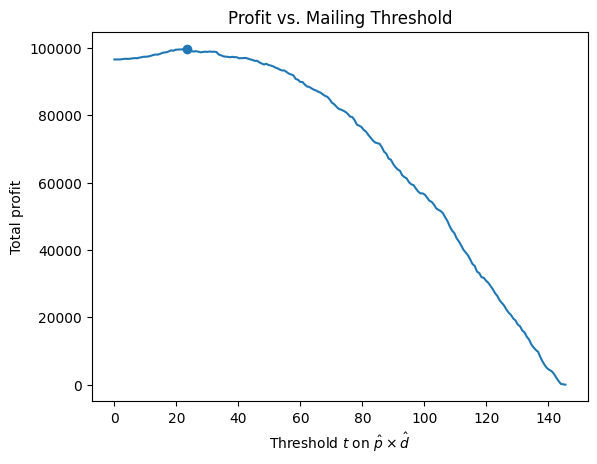

(23.391674347271774, 99808.10909443504)

In [ ]:
import matplotlib.pyplot as plt

pred_expected = p_hat * d_hat

# Profit curve across thresholds
thresholds = np.linspace(0, pred_expected.max(), 200)
profits = []
for t in thresholds:
    mail = pred_expected > t
    profit = (mail & (df['respond'] == 1)) * (df['donation'] - c) + (mail & (df['respond'] == 0)) * (-c)
    profits.append(profit.sum())

profits = np.array(profits)
best_idx = profits.argmax()
best_threshold = thresholds[best_idx]
best_profit = profits[best_idx]

# Plot
plt.plot(thresholds, profits)
plt.scatter([best_threshold], [best_profit])
plt.xlabel("Threshold $t$ on $\\hat p \\times \\hat d$")
plt.ylabel("Total profit")
plt.title("Profit vs. Mailing Threshold")
plt.show()

best_threshold, best_profit


### 3.3  Beware of *Selection Bias*
The regression for $d_R(x)$ is fit **only on responders**; if high‑value donors are *less* likely to respond, the model under‑estimates $d_R(x)$ for non‑responders.  Remedies:
* *Inverse‑propensity weighting* (Zadrozny & Elkan 2001).
* Deliberate sampling or experimentation to observe more responses.
* Bayesian hierarchical models sharing information across classes.

## 4  Case Study B – Churn Retention Incentives
### 4.1  Business Setting
A telecom gives selective discounts (cost `$c` per customer) to reduce contract cancellation (*churn*).
Key quantities:
* $p_S(T\mid x)$ – probability customer $x$ stays **with** incentive ( $T$ reatment).
* $p_S(C\mid x)$ – probability stays **without** incentive ( $C$ ontrol).
* $u_S(x)$ – profit if the customer stays (e.g., lifetime value).

### 4.2  Value of Treatment (Incremental Lift)
With incentive:
$$
\operatorname{EV}(T) = p_S(T\mid x)\,u_S(x) - c.
$$
Without incentive:
$$
\operatorname{EV}(C) = p_S(C\mid x)\,u_S(x).
$$
Thus the **incremental expected profit** (*uplift*) is
$$
VT(x) = \bigl[p_S(T\mid x) - p_S(C\mid x)\bigr]\,u_S(x) - c.
$$
Offer the incentive **iff** (if and only if) $VT(x) > 0$.

### 4.3  Estimating the Two Probabilities
A standard approach is to train **two separate classifiers**—one on treated customers, one on control—
or to use *uplift models* that learn the difference directly.  Randomized historical campaigns are crucial so that treatment assignment is *independent* of $x$ (unconfounded).

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def make_churn_data(n=6000, seed=10):
    rng = np.random.default_rng(seed)
    X = rng.standard_normal((n,4))
    treat = rng.binomial(1, 0.5, size=n)
    base_p = 1/(1+np.exp(-(X @ np.array([-1.2, 0.5, 0.3, -0.6]))))
    uplift = 0.2                        # treatment lifts retention by 20‑points
    p_stay = np.clip(base_p + uplift*treat, 0, 1)
    stay = rng.binomial(1, p_stay)
    value = rng.normal(80, 15, size=n)
    return pd.DataFrame(np.c_[X, treat, stay, value],
                        columns=['x1','x2','x3','x4','treat','stay','value'])

dfc = make_churn_data()
feat = ['x1','x2','x3','x4']

clf_T = GradientBoostingClassifier().fit(dfc[dfc.treat==1][feat], dfc[dfc.treat==1]['stay'])
clf_C = GradientBoostingClassifier().fit(dfc[dfc.treat==0][feat], dfc[dfc.treat==0]['stay'])

p_T = clf_T.predict_proba(dfc[feat])[:,1]
p_C = clf_C.predict_proba(dfc[feat])[:,1]
delta_p = p_T - p_C
c = 25  # incentive cost
VT = delta_p * dfc['value'] - c
dfc['offer'] = VT > 0
print('Offer fraction =', dfc.offer.mean().round(3))
print('Expected uplift profit =', VT[dfc.offer].sum().round(2))

Offer fraction = 0.151
Expected uplift profit = 6067.41


Cumulative profit vs. fraction of customers offered

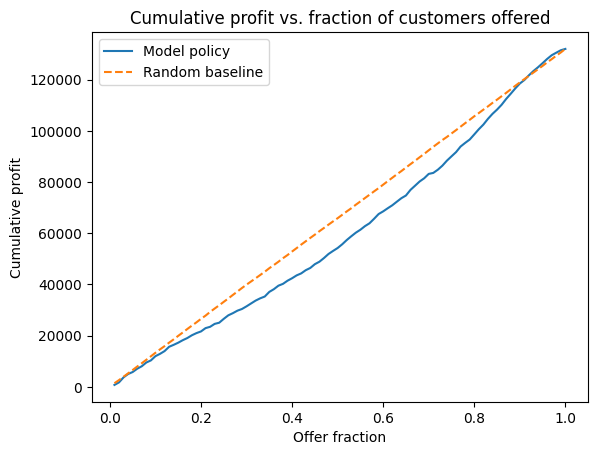

(1.0, 132017.68902618988)

In [ ]:
dfc['VT'] = VT

# Sort by VT (highest expected incremental profit first)
df_sorted = dfc.sort_values('VT', ascending=False).reset_index(drop=True)

cum_profit = []
offer_fracs = np.linspace(0.01, 1.0, 100)
for frac in offer_fracs:
    k = int(frac * len(df_sorted))
    offer_idx = np.arange(k)
    # Net profit: if offered & stayed => +value - c
    #             if offered & churned => -c
    offered = df_sorted.loc[offer_idx]
    profit = (offered['stay'] * offered['value'] - c).sum()
    cum_profit.append(profit)

# Random baseline (average over 50 shuffles)
rand_profits = np.zeros_like(offer_fracs)
for _ in range(50):
    shuffled = dfc.sample(frac=1.0, replace=False, random_state=np.random.randint(0,1e6))
    rp = []
    for frac in offer_fracs:
        k = int(frac * len(shuffled))
        subset = shuffled.iloc[:k]
        rp.append((subset['stay']*subset['value'] - c).sum())
    rand_profits += np.array(rp)
rand_profits /= 50

# Plot cumulative profit curves
plt.figure()
plt.plot(offer_fracs, cum_profit, label='Model policy')
plt.plot(offer_fracs, rand_profits, linestyle='--', label='Random baseline')
plt.xlabel("Offer fraction")
plt.ylabel("Cumulative profit")
plt.title("Cumulative profit vs. fraction of customers offered")
plt.legend()
plt.show()

# Display key metrics
best_idx = np.argmax(cum_profit)
best_frac = offer_fracs[best_idx]
best_profit = cum_profit[best_idx]
best_frac, best_profit


## 5  Practical Pitfalls & Engineering Tips
* **Confounding & Randomization** – Without randomized data you cannot reliably estimate $p_S(C\mid x)$.
* **Delayed Feedback** – Value $u_S(x)$ may accrue over months; discount future cash flows.
* **Computation vs. Value** – Complex models should justify their extra cost by larger EV gains.
* **Regulatory & Ethical Constraints** – e.g., disparate impact when incentives target a protected group.

## 6  Summary
* *Analytical Engineering* frames business choices as *expected value* calculations.
* Mathematical decomposition isolates *probability* and *value* pieces, both amenable to data science.
* Two case studies illustrated concrete threshold rules: $p(R)d_R>c$ for mailings and
  $(p_T-p_C)u_S>c$ for churn retention.
* Success hinges on good data (especially randomized experiments) and vigilance against bias.